## Create BM25 Index
Here we create the BM25 index. This is required for our custom Hybrid search engine, wherein it will be used as the sparse retrieval layer.

#### Methodology
Some background -
- Relying on a single embedding of description is brittle.
- Dense embedding search on a large corpus of documents is time consuming
- Due to the nature of certain documents (containing thousands of rows), creating a dense-embedding of each document will mask context around certain keywords. Due to this, dense-embeddings may fail at throwing relevant documents even when there are instances of keyword match, due to the sheer size of the document, due to which the keyword matches get masked behind the dense-embeddings.

To counter this, BM25 based retrieval will be used as the first layer, because it is efficient, and less RAM intensive than dense retrieval models. These will rely on exact-term matching. These are lightweight, and will allow us to reduce the search space from thousands of candidate documents to a few hundred "possibly" relevant documents.

Having said that, here's a good read on sparse vs dense retrievals - [SPLADE for Sparse Vector Search Explained](https://www.pinecone.io/learn/splade/).

Let's get started.

#### 1. Load the CSO dump

In [1]:
from pathlib import Path
import os

root = Path().absolute().parents[1]
os.chdir(str(root))

from src.helpers.json_stat_archive_db import JSONStatArchiveDB

In [2]:
db = JSONStatArchiveDB(compression_level=12)

cso_files = {}
for tid, ds, ts in db.read("artifacts/cso_bkp/cso_archive/jsonstat_archive.sqlite", table_id=None, with_labels=True):
    cso_files[tid] = {
        "data": ds,
        "timestamp": ts,
    }

In [3]:
len(cso_files)

12435

### 2. Create the bag-of-words for each document

In [ ]:
def get_bag_of_words(cso_file: str) -> str:
    """Generate a bag of words from the JSON data."""
    col_dist_vals_dic = {}

    col_ids = cso_file['id']
    label = cso_file['label']
    subject = cso_file['extension']['subject']['value']
    product = cso_file['extension']['product']['value']
    table_id = cso_file['extension']["matrix"]

    for col_id in col_ids:
        col_name = cso_file['dimension'][col_id]['label']
        if col_id.startswith("TLIST"):
            continue
        else:
            col_dist_vals_dic[col_name] = list(cso_file['dimension'][col_id]['category']['label'].values())

    # combine the label, subject, product and column name and distribution values into a single string
    combined_str = f"""{table_id} - {label} - {subject} - {product} - {" ".join([key for key in col_dist_vals_dic.keys()] + [" ".join(val) for val in col_dist_vals_dic.values()])}"""

    return {"id": table_id, "text": combined_str}

corpus = [get_bag_of_words(item["data"]) for item in cso_files.values()]

### 3. Create BM25 index and save them for future use

In [ ]:
import bm25s
import Stemmer

# Tokenize texts
stemmer = Stemmer.Stemmer("english")
texts = [d["text"] for d in corpus]
corpus_tokens = bm25s.tokenize(texts, stopwords="en", stemmer=stemmer)

# Index (attach corpus so save/load keeps it)
retriever = bm25s.BM25(corpus=corpus)
retriever.index(corpus_tokens)

# Save the indices (corpus.jsonl will contain the table-ids/texts)
retriever.save("artifacts/bm25")

Finding newlines for mmindex: 100%|██████████| 71.1M/71.1M [00:00<00:00, 1.53GB/s]


In [ ]:
import json

# EXAMPLE USAGE:

# 1. load corpus
f = open("artifacts/bm25/corpus.jsonl", "r")
corpus_new = [json.loads(line) for line in f]
f.close()

# 2. load retriever
new_retriever = retriever.load("artifacts/bm25")



# 3. ask a question, tokenize it
question = "What's the mining and quarrying production in Ireland?"
query_tokens = bm25s.tokenize(question, stemmer=stemmer)

# 4. get docs + scores (note: pass corpus=corpus; no return_as)
docs, scores = new_retriever.retrieve(query_tokens, k=10, corpus=corpus_new)

for i in range(docs.shape[1]):
    doc, score = docs[0, i], scores[0, i]
    print(f"Rank {i+1} (score: {score:.2f}): id={doc['id']} text={doc['text']}")

Rank 1 (score: 8.05): id=CD907 text=Population Aged 15 Years and Over at Work - Census 2011 - Profile 9 - What we Know - A study of Education and Skills in Ireland - Statistic Sex Highest Level of Education Completed Detailed Industrial Group Population Aged 15 Years and Over at Work Both sexes Male Female Total education ceased and not ceased Total whose full-time education has ceased No formal education Primary Lower secondary Upper secondary Technical/vocational Advanced certificate/completed apprenticeship Higher certificate Ordinary bachelor degree/professional qualification or both Honours bachelor degree/professional qualification or both Postgraduate diploma or degree Doctorate (Ph.D.) Not stated Total whose full-time education has not ceased Growing of perennial and non-perennial crops plant propagation (011,012,013) Farming  of animals mixed farming (0141, 0142, 0144 to 0150) Hunting and agricultural related activities  (016,017) Forestry and logging (02) Fishing and aquacult

In [40]:
docs, scores = new_retriever.retrieve(query_tokens, k=10, corpus=corpus_new)
docs

array([[{'id': 'CD907', 'text': 'Population Aged 15 Years and Over at Work - Census 2011 - Profile 9 - What we Know - A study of Education and Skills in Ireland - Statistic Sex Highest Level of Education Completed Detailed Industrial Group Population Aged 15 Years and Over at Work Both sexes Male Female Total education ceased and not ceased Total whose full-time education has ceased No formal education Primary Lower secondary Upper secondary Technical/vocational Advanced certificate/completed apprenticeship Higher certificate Ordinary bachelor degree/professional qualification or both Honours bachelor degree/professional qualification or both Postgraduate diploma or degree Doctorate (Ph.D.) Not stated Total whose full-time education has not ceased Growing of perennial and non-perennial crops plant propagation (011,012,013) Farming  of animals mixed farming (0141, 0142, 0144 to 0150) Hunting and agricultural related activities  (016,017) Forestry and logging (02) Fishing and aquaculture

#### Chunking BM25 corpus
Background -
- Long-document dilution / verbosity bias can bring down the BM25 score for documents that are huge in size.
- Scoring then b y max passage score per table can eliminate dilution while keeping recall

First we'll visualise the problem.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json

In [ ]:
# load corpus
with open("artifacts/bm25/corpus.jsonl", "r") as f:
    corpus = [json.loads(line) for line in f]

/opt/anaconda3/envs/python311/lib/python3.11/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/python311/lib/python3.11/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/python311/lib/python3.11/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


(0.0, 2000.0)

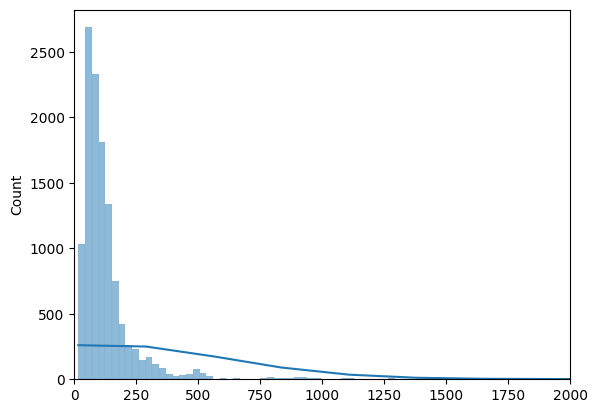

In [5]:
word_lengths = [
    len(x["text"].split(" "))
    for x in corpus
]
# plot word length distribution using seaborn
sns.histplot(word_lengths, bins=2000, kde=True)

# set limit on x-axis to 500
plt.xlim(0, 2000)

In [9]:
lengths_list = []

for item in corpus:
    lengths_list.append(
        {
            "id": item["id"],
            "word_length": len(item["text"].split(" ")),
            "character_length": len(item["text"])
        }
    )

lengths_df = pd.DataFrame(lengths_list)
lengths_df.sort_values(by="word_length", ascending=False, inplace=True)
lengths_df.reset_index(drop=True, inplace=True)
print(lengths_df.shape)
# categorise word_length into buckets of 50 (0-50, 50-100, and so on) and then
lengths_df["word_length_bucket"] = pd.cut(lengths_df["word_length"], bins=range(0, 54400, 80), right=False)
lengths_df[:20]

(12435, 3)


,id,word_length,character_length,word_length_bucket
0,PCA16,54301,387666,"[54240, 54320)"
1,PCA17,54301,387666,"[54240, 54320)"
2,PCA22,49258,343844,"[49200, 49280)"
3,PCA20,47046,336662,"[47040, 47120)"
4,PCA02,45184,351216,"[45120, 45200)"
5,PCA01,44998,350753,"[44960, 45040)"
6,PCA03,44158,343819,"[44080, 44160)"
7,PCA14,43442,291401,"[43440, 43520)"
8,PCA23,42848,307906,"[42800, 42880)"
9,PCA18,39499,328553,"[39440, 39520)"


### Document-split and re-generate BM25 index
#### Stage-1 Improvements
Possible improvements for stage-1
- chunking and tagging of very long documents
    - create a distribution of document lengths to analyse the average doc-length, and the how long the tail is
- k1 parameter tuning (default is 1.5, ranges from 0-3, can be lowered to penalise frequently occuring terms in a doc, like "kg")

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter


def get_chunked_bag_of_words(cso_file: str) -> str:
    """Generate a bag of words from the JSON data."""
    col_dist_vals_dic = {}

    col_ids = cso_file['id']
    label = cso_file['label']
    subject = cso_file['extension']['subject']['value']
    product = cso_file['extension']['product']['value']
    table_id = cso_file['extension']["matrix"]

    for col_id in col_ids:
        col_name = cso_file['dimension'][col_id]['label']
        if col_id.startswith("TLIST"):
            continue
        else:
            col_dist_vals_dic[col_name] = list(cso_file['dimension'][col_id]['category']['label'].values())

    # combine the label, subject, product and column name and distribution values into a single string
    # combined_str = f"""{label} - {subject} - {product} - {" ".join([key for key in col_dist_vals_dic.keys()] + [" ".join(val) for val in col_dist_vals_dic.values()])}"""
    header_str = f"""{table_id} - {label} - {subject} - {product} - {" ".join([key for key in col_dist_vals_dic.keys()])}"""
    batch_size = 80
    values_dump = []
    for vals_list in col_dist_vals_dic.values():
        values_dump.extend(vals_list)

    values_dump = " ".join(values_dump)
    
    text_splitter = RecursiveCharacterTextSplitter(
        # Set a really small chunk size, just to show.
        chunk_size=1000,
        chunk_overlap=20,
        length_function=len,
        is_separator_regex=False,
    )
    corpus = text_splitter.create_documents([values_dump])
    corpus = [header_str + x.page_content for x in corpus]
    chunks = [
        {"id": table_id, "text": x} for x in corpus
    ]

    return chunks

corpus = []

for cso_file in cso_files.values():
    corpus.extend(get_chunked_bag_of_words(cso_file["data"]))

In [5]:
len(corpus)

77438

/opt/anaconda3/envs/python311/lib/python3.11/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/python311/lib/python3.11/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/anaconda3/envs/python311/lib/python3.11/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


<Axes: ylabel='Count'>

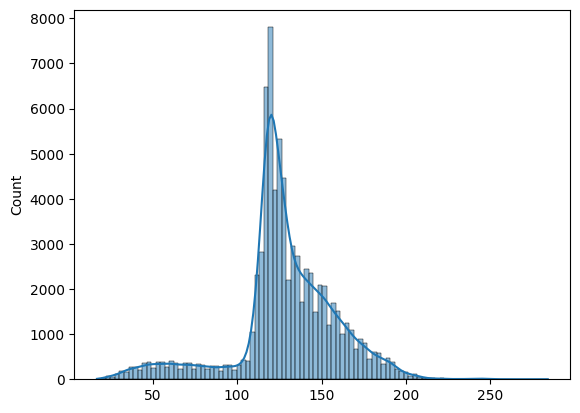

In [7]:
import seaborn as sns

word_lengths = [
    len(x["text"].split(" "))
    for x in corpus
]
# plot word length distribution using seaborn
sns.histplot(word_lengths, bins=100, kde=True)

# set limit on x-axis to 500
# plt.xlim(0, 2000)

In [10]:
import pandas as pd


lengths_list = []

for item in corpus:
    lengths_list.append(
        {
            "id": item["id"],
            "word_length": len(item["text"].split(" ")),
            "character_length": len(item["text"])
        }
    )

lengths_df = pd.DataFrame(lengths_list)
lengths_df.sort_values(by="word_length", ascending=False, inplace=True)
lengths_df.reset_index(drop=True, inplace=True)
print(lengths_df.shape)
# categorise word_length into buckets of 50 (0-50, 50-100, and so on) and then
lengths_df["word_length_bucket"] = pd.cut(lengths_df["word_length"], bins=range(0, 16000, 80), right=False)
lengths_df

(77438, 3)


,id,word_length,character_length,word_length_bucket
0,MEG01,284,1096,"[240, 320)"
1,MEG02,284,1096,"[240, 320)"
2,MEG03,260,930,"[240, 320)"
3,E9035,255,1205,"[240, 320)"
4,F8014,255,1189,"[240, 320)"
...,...,...,...,...
77433,EAA20,19,130,"[0, 80)"
77434,PFSA04,18,107,"[0, 80)"
77435,PCA23,18,125,"[0, 80)"
77436,IFS75,18,110,"[0, 80)"


In [11]:
import bm25s
import Stemmer

# Tokenize texts
stemmer = Stemmer.Stemmer("english")
texts = [d["text"] for d in corpus]
corpus_tokens = bm25s.tokenize(texts, stopwords="en", stemmer=stemmer)

# Index (attach corpus so save/load keeps it)
retriever = bm25s.BM25(corpus=corpus)
retriever.index(corpus_tokens)

# Save the indices (corpus.jsonl will contain the table-ids/texts)
retriever.save("artifacts/bm25")

/opt/anaconda3/envs/python311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Finding newlines for mmindex: 100%|██████████| 83.8M/83.8M [00:00<00:00, 344MB/s]


In [145]:
# 4) Query
question = "does the fish purr like a cat?"

question = "What's the electricity generation mix in Ireland? for renewable and non-renewable energy?"
# question = "What is the share of renewable energy in Ireland?"
# question = "What's the breakup between renewable and non-renewable energy production in Ireland?"
question = "Ireland rural vs urban population mix"
# question = "What are ireland's top exports?"
# question = "What are Prodcom sales for skincare beauty and makeup products in 2023?"
# question = "Give me a breakup of Ireland's share of transportation sector."
# question = "Sold productions - quantity (kg) for beauty, makeup and skincare preparations in Ireland in 2023?"
# question = "beauty makeup and skin care production in prodcom data for ireland in 2023"
# question = "PRODCOM production quantity."
# question = "What's the mining and quarrying production in Ireland?"
# question = "nano cellulose production in ireland"
# question = "give me pharmaceuticals production in ireland"
# question = "what are the different types of pharmaceuticals products produced in ireland"


query_tokens = bm25s.tokenize(question, stemmer=stemmer)

# 4. get docs + scores (note: pass corpus=corpus; no return_as)
docs, scores = retriever.retrieve(query_tokens, k=10, corpus=corpus)

for i in range(docs.shape[1]):
    doc, score = docs[0, i], scores[0, i]
    print(f"Rank {i+1} (score: {score:.2f}): id={doc['id']} text={doc['text']}")

Rank 1 (score: 8.44): id=G0612 text=SDG 6.3.2 Waterbody Status in Ireland vs EU27 Average - UN Sustainable Development Goals - Goal 6 - Clean Water and Sanitation - Statistic Waterbody Status CountryWaterbody status High Good Moderate Poor Bad Status unknown Ireland EU27 countries (from 2020)
Rank 2 (score: 5.90): id=CPNI14 text=Population Usually Resident - Ireland and Northern Ireland - Census 2022 - Ireland and Northern Ireland - A Joint Census Publication 2021-2022 - Statistic Ireland and Northern Ireland EthnicityPopulation Usually Resident Percentage of Population Usually Resident Ireland Northern Ireland White Irish Traveller Asian Black Other including mixed background Not stated All ethnic or cultural backgrounds
Rank 3 (score: 5.62): id=URA15 text=Profile of Population at Risk of Poverty and in Consistent Poverty - Life in Ireland - Urban and Rural Life in Ireland - Type of Urban or Rural Area StatisticState Cities Satellite urban towns Independent urban towns Rural areas wit